Part 2: Twin Spirals Task

1.
class PolarNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(PolarNet, self).__init__()
        self.fc1 = nn.Linear(2, num_hid)
        self.fc2 = nn.Linear(num_hid, 1)

    def forward(self, input):
        # r=sqrt(x*x + y*y), a=atan2(y,x)
        converted = []
        for x,y in input:
            r= math.sqrt(x*x + y*y)
            a= math.atan2(y,x)
            converted.append([r,a])
        converted = torch.Tensor(converted)
        to_hidden = torch.tanh(self.fc1(converted))
        self.h1 = to_hidden
        output = self.fc2(to_hidden)
        output = F.sigmoid(output)
        return output

2. minimum number of hidden nodes required is 8 to train PolarNet to 100% of accuracy.

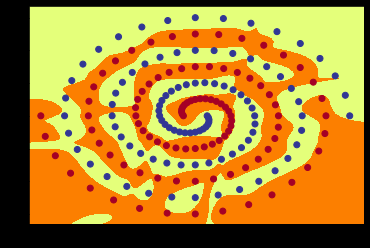

3. 
class RawNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(RawNet, self).__init__()
        # INSERT CODE HERE
        self.fc1 = nn.Linear(2, num_hid)
        self.fc2 = nn.Linear(num_hid, num_hid)
        self.fc3 = nn.Linear(num_hid, 1)

    def forward(self, input):
        to_hidden1 = torch.tanh(self.fc1(input))
        self.h1 = to_hidden1
        to_hidden2 = torch.tanh(self.fc2(to_hidden1))
        self.h2 = to_hidden2
        output = self.fc3(to_hidden2)
        output = F.sigmoid(output)
        return output

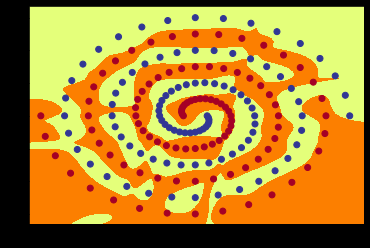

4.
the size of the initial weights is 0.3

a. There are differences in the diagrams produced on the hidden layer and the final output between different models. Within the hidden layer of polar net, nodes are producing output with curves that fit well to the spirial data in the diagram. The other two models have most straight lines. In the second layer of raw and short net, curves started to become more prevalent. The outcome are closer to the hidden layer output of polar, but there are still noises in the diagrams. 

Networks use activation functions to determine whether a node should fire a signal or not. Additional diagrams were generated to visualize the output of three models(*_act.png) with node ID on x-axis and tanh value on y-axis. After comparing the diagrams of activation function, it was found the faster a model was trained, the more polarized the values in the diagrams were. Polarized in this case means activation values were concentrated to both 1 and -1, which indicated how certain a node was to either fire or not fire the signal. For example, polar net is the most optimized model. The activation values are highly concentrated around 1 and -1. Although the other two models could also classify the data correctly, their activation function are more evenly spreaded between -1 and 1. There were also nodes that always fire or not fire, which were not helpful, too. This suggestss most nodes in raw and short net were unsure about firing. It was also reflected in the generated spiral diagram (graph_output) which has more sharp edges in comparison. Nodes that did manage to have polarized value were believed to be the one that carried the model through the training. Polar net on the other hand, has more nature and smooth curves.

b. The initial wieght set the variance of the normal distribution function used for calcualting the loss function. Having the right init value would more likely successfully train the model faster. Having a value too low or too high would lead to slow improvemnet of accuracy and a lower chance of success. The optimal value was found by trial and error. For example, it was found setting init as 0.3, 0.6 and 0.8 could all reach 100% for the Raw model. However, 0.3 took less than 7500 epochs while the other two both took over 15000. After further experientations, an init of 0.3 turned out to be the most  consistent. On the other hand, the short model is best performing with init set as 0.2. This suggests the optimal value varies depend on the model.

c. The polar net model is the most natural model out of the three. It has been optimized with math formula. It puts a strong emphasis on the importance of fine tuning a model. The learning process could be greatly improved if our understanding of the task as human beings could be translated into logical or mathmatically representations. Should guidance as such be available, a neural network could be simplified in structure while enjoying a shorter training time and a more natural result. In this case, the formula specializes a general purposed network as an expert in recognizing spirals. Vice versa, the absent of the guidance would require additional computational power and more complex structure as compensations for a network to be trained with most likely a less desirable result. 

d.
Experiments were done. The changes made for the experiement were removed befor modifying the net value.

With torch.optim.SGD: it involves the removal of some parameters such as eps and beta. Momentum could be added. The accuracy could reach 75% after some fine tuning in raw.  

With an additional hidden layer of 10 node: In raw net, tt was noticed that if the model did end up reaching 100% of accuracy then it could do it quicker than before. However, there are time when the accuracy sufffers from large scale flutuations. For example, there are times when the accuracy would drop from high 90% to the low 80% for a few (100s) epochs then raised back. Therefore, it was believed that excessive layers would not benefit the training of a model. 

With double the batch size to 194, all three net could be trained in half of the time. For example, polar net in about 1000 epochs. And short net in between 5000 to 9000 epochs. 

Replacing tanh with relu as the activation function has a negative effect on the polar model that it would take 50% more epochs to train (from 2200 epoch to 3500 epochs). Raw and short net also suffers that their accuracy would drop to around 85% - 95% by the end of the training. 


In [1]:
# spiral_main.py
# COMP9444, CSE, UNSW

import torch
import torch.utils.data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
from spiral import PolarNet, RawNet, ShortNet, graph_hidden
import torch.nn as nn

def train(net, train_loader, optimizer):
    total=0
    correct=0
    for batch_id, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()    # zero the gradients
        output = net(data)       # apply network
        loss = F.binary_cross_entropy(output,target)
        loss.backward()          # compute gradients
        optimizer.step()         # update weights
        pred = (output >= 0.5).float()
        correct += (pred == target).float().sum()
        total += target.size()[0]
        accuracy = 100*correct/total

    if epoch % 100 == 0:
        print('ep:%5d loss: %6.4f acc: %5.2f' %
             (epoch,loss.item(),accuracy))

    return accuracy

def graph_output(net):
    xrange = torch.arange(start=-7,end=7.1,step=0.01,dtype=torch.float32)
    yrange = torch.arange(start=-6.6,end=6.7,step=0.01,dtype=torch.float32)
    xcoord = xrange.repeat(yrange.size()[0])
    ycoord = torch.repeat_interleave(yrange, xrange.size()[0], dim=0)
    grid = torch.cat((xcoord.unsqueeze(1),ycoord.unsqueeze(1)),1)

    with torch.no_grad(): # suppress updating of gradients
        net.eval()        # toggle batch norm, dropout
        output = net(grid)
        net.train() # toggle batch norm, dropout back again

        pred = (output >= 0.5).float()

        # plot function computed by model
        plt.clf()
        plt.pcolormesh(xrange,yrange,pred.cpu().view(yrange.size()[0],xrange.size()[0]), cmap='Wistia')

#parser = argparse.ArgumentParser()
#parser.add_argument('--net',type=str,default='raw',help='polar, raw or short')
#parser.add_argument('--init',type=float,default=0.1,help='initial weight size')
#parser.add_argument('--hid',type=int,default='10',help='number of hidden units')
#parser.add_argument('--lr',type=float,default=0.01,help='learning rate')
#parser.add_argument('--epochs',type=int,default='100000',help='max training epochs')
#args = parser.parse_args()
argnet = 'raw'
init = 0.1
hid = 10
lr = 0.01
epochs = 100000

device = 'cpu'

df = pd.read_csv('spirals.csv')

data = torch.tensor(df.values,dtype=torch.float32)

num_input = data.shape[1] - 1

full_input  = data[:,0:num_input]
full_target = data[:,num_input:num_input+1]

train_dataset = torch.utils.data.TensorDataset(full_input,full_target)
train_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=97)


In [100]:
# create neural network

import math 
class PolarNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(PolarNet, self).__init__()
        self.fc1 = nn.Linear(2, num_hid)
        self.fc2 = nn.Linear(num_hid, 1)
        # INSERT CODE HERE

    def forward(self, input):
        #print('input', input)
        #print(input.shape)
        # r=sqrt(x*x + y*y), a=atan2(y,x)
        converted = []
        for x,y in input:
            r= math.sqrt(x*x + y*y)
            a= math.atan2(y,x)
            converted.append([r,a])
        converted = torch.Tensor(converted)
        to_hidden = torch.tanh(self.fc1(converted))
        self.h1 = to_hidden
        output = self.fc2(to_hidden)
        #output = 0*input[:,0] # CHANGE CODE HERE
        output = F.sigmoid(output)
        #print('output', output)
        #print(output.shape)
        return output
    
argnet = 'polar'
epochs = 20000 
hid = 8

if argnet == 'polar':
    net = PolarNet(hid)
elif net == 'short':
    net = ShortNet(hid)
else:
    net = RawNet(hid)

if list(net.parameters()):
    # initialize weight values
    for m in list(net.parameters()):
        m.data.normal_(0,init)

    optimizer = torch.optim.Adam(net.parameters(),eps=0.000001,lr=lr,
                                 betas=(0.9,0.999),weight_decay=0.0001)

    for epoch in range(1, epochs):
        accuracy = train(net, train_loader, optimizer)
        if epoch % 100 == 0 and accuracy == 100:
            break

ep:  100 loss: 0.6658 acc: 53.61
ep:  200 loss: 0.5884 acc: 60.31
ep:  300 loss: 0.3856 acc: 66.49
ep:  400 loss: 0.2910 acc: 65.98
ep:  500 loss: 0.1916 acc: 72.68
ep:  600 loss: 0.1315 acc: 75.26
ep:  700 loss: 0.1035 acc: 75.26
ep:  800 loss: 0.0824 acc: 80.41
ep:  900 loss: 0.0666 acc: 81.44
ep: 1000 loss: 0.0551 acc: 84.54
ep: 1100 loss: 0.0472 acc: 90.72
ep: 1200 loss: 0.0413 acc: 90.21
ep: 1300 loss: 0.0358 acc: 90.21
ep: 1400 loss: 0.0298 acc: 90.72
ep: 1500 loss: 0.0237 acc: 91.75
ep: 1600 loss: 0.0202 acc: 99.48
ep: 1700 loss: 0.0165 acc: 100.00


In [33]:
print(net)

PolarNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


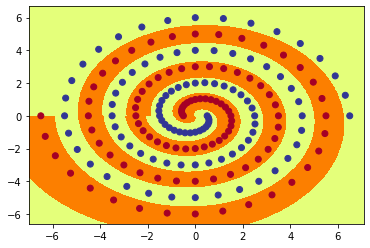

In [101]:
argnet = "polar"
for layer in [1,2]:
    if layer == 1 or argnet != 'polar':
        for node in range(hid):
            graph_hidden(net, layer, node)
            plt.scatter(full_input[:,0],full_input[:,1],
                        c=1-full_target[:,0],cmap='RdYlBu')
            plt.savefig('%s%d_%d.png' % (argnet, layer, node))

graph_output(net)
plt.scatter(full_input[:,0],full_input[:,1],
            c=1-full_target[:,0],cmap='RdYlBu')
plt.savefig('%s_out.png' % argnet)


In [70]:
# Include in your report the number of hidden nodes, and the values of any other metaparameters.

class RawNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(RawNet, self).__init__()
        # INSERT CODE HERE
        self.fc1 = nn.Linear(2, num_hid)
        self.fc2 = nn.Linear(num_hid, num_hid)
        self.fc3 = nn.Linear(num_hid, 1)

    def forward(self, input):
        to_hidden1 = torch.tanh(self.fc1(input))
        self.h1 = to_hidden1
        to_hidden2 = torch.tanh(self.fc2(to_hidden1))
        self.h2 = to_hidden2
        output = self.fc3(to_hidden2)
        #output = 0*input[:,0] # CHANGE CODE HERE
        output = F.sigmoid(output)
        return output

argnet = "raw"
init = 0.3
hid = 10
net = RawNet(hid)

if list(net.parameters()):
    # initialize weight values
    for m in list(net.parameters()):
        m.data.normal_(0,init)

    optimizer = torch.optim.Adam(net.parameters(),eps=0.000001,lr=lr,
                                 betas=(0.9,0.999),weight_decay=0.0001)

    for epoch in range(1, epochs):
        accuracy = train(net, train_loader, optimizer)
        if epoch % 100 == 0 and accuracy == 100:
            break
            

ep:  100 loss: 0.6656 acc: 62.89
ep:  200 loss: 0.6024 acc: 55.15
ep:  300 loss: 0.4587 acc: 70.10
ep:  400 loss: 0.3842 acc: 75.77
ep:  500 loss: 0.1894 acc: 92.27
ep:  600 loss: 0.1264 acc: 94.33
ep:  700 loss: 0.1059 acc: 95.88
ep:  800 loss: 0.0817 acc: 96.39
ep:  900 loss: 0.0730 acc: 96.91
ep: 1000 loss: 0.0687 acc: 96.39
ep: 1100 loss: 0.0665 acc: 96.39
ep: 1200 loss: 0.0650 acc: 96.39
ep: 1300 loss: 0.0638 acc: 96.91
ep: 1400 loss: 0.0623 acc: 96.91
ep: 1500 loss: 0.0593 acc: 96.91
ep: 1600 loss: 0.0561 acc: 96.39
ep: 1700 loss: 0.0504 acc: 97.42
ep: 1800 loss: 0.0479 acc: 97.94
ep: 1900 loss: 0.0466 acc: 97.94
ep: 2000 loss: 0.0457 acc: 97.94
ep: 2100 loss: 0.0451 acc: 97.94
ep: 2200 loss: 0.0447 acc: 97.94
ep: 2300 loss: 0.0443 acc: 97.42
ep: 2400 loss: 0.0440 acc: 97.42
ep: 2500 loss: 0.0438 acc: 97.42
ep: 2600 loss: 0.0436 acc: 97.42
ep: 2700 loss: 0.0424 acc: 97.94
ep: 2800 loss: 0.0418 acc: 97.94
ep: 2900 loss: 0.0419 acc: 97.94
ep: 3000 loss: 0.0420 acc: 97.94
ep: 3100 l

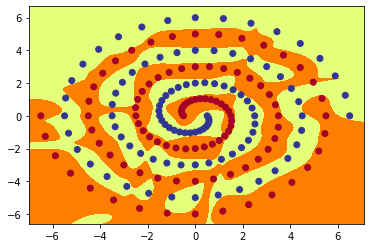

In [50]:
for layer in [1,2]:
    if layer == 1 or argnet != 'polar':
        for node in range(hid):
            graph_hidden(net, layer, node)
            plt.scatter(full_input[:,0],full_input[:,1],
                        c=1-full_target[:,0],cmap='RdYlBu')
            plt.savefig('%s%d_%d.png' % (argnet, layer, node))

graph_output(net)
plt.scatter(full_input[:,0],full_input[:,1],
            c=1-full_target[:,0],cmap='RdYlBu')
plt.savefig('%s_out.png' % argnet)

In [9]:
class ShortNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(ShortNet, self).__init__()
        self.fc1 = nn.Linear(2, num_hid)
        self.fc2 = nn.Linear(num_hid, num_hid)
        self.fc3 = nn.Linear(num_hid, 1)
        self.fc4 = nn.Linear(2, 1)

    def forward(self, input):
        input_to_h = torch.tanh(self.fc1(input))
        input_to_out = self.fc4(input)
        
        h1_to_h2 = torch.tanh(self.fc2(input_to_h)+input_to_h)
        
        h1_to_out = self.fc3(input_to_h)
        h2_to_output = self.fc3(input_to_h + h1_to_h2)
        output = torch.sigmoid(input_to_out+h1_to_out+h2_to_output)
        
        self.h1 = input_to_h
        self.h2 = h1_to_h2
            
        return output

argnet = "short"
init = 0.2
hid = 14

net = ShortNet(hid)

if list(net.parameters()):
    # initialize weight values
    for m in list(net.parameters()):
        m.data.normal_(0,init)

    optimizer = torch.optim.Adam(net.parameters(),eps=0.000001,lr=lr,
                                 betas=(0.9,0.999),weight_decay=0.0001)

    for epoch in range(1, epochs):
        accuracy = train(net, train_loader, optimizer)
        if epoch % 100 == 0 and accuracy == 100:
            break

ep:  100 loss: 0.6826 acc: 64.95
ep:  200 loss: 0.6733 acc: 64.95
ep:  300 loss: 0.6636 acc: 64.43
ep:  400 loss: 0.6483 acc: 65.98
ep:  500 loss: 0.6210 acc: 65.46
ep:  600 loss: 0.5819 acc: 58.25
ep:  700 loss: 0.5227 acc: 60.82
ep:  800 loss: 0.4728 acc: 62.37
ep:  900 loss: 0.4280 acc: 64.95
ep: 1000 loss: 0.3910 acc: 63.40
ep: 1100 loss: 0.3564 acc: 64.43
ep: 1200 loss: 0.3182 acc: 67.01
ep: 1300 loss: 0.2797 acc: 69.59
ep: 1400 loss: 0.2478 acc: 70.10
ep: 1500 loss: 0.2196 acc: 70.62
ep: 1600 loss: 0.1979 acc: 72.68
ep: 1700 loss: 0.1821 acc: 74.23
ep: 1800 loss: 0.1701 acc: 73.71
ep: 1900 loss: 0.1614 acc: 73.71
ep: 2000 loss: 0.1548 acc: 74.74
ep: 2100 loss: 0.1481 acc: 75.26
ep: 2200 loss: 0.1413 acc: 75.77
ep: 2300 loss: 0.1348 acc: 76.29
ep: 2400 loss: 0.1289 acc: 76.80
ep: 2500 loss: 0.1211 acc: 78.35
ep: 2600 loss: 0.1140 acc: 79.38
ep: 2700 loss: 0.1086 acc: 80.41
ep: 2800 loss: 0.1011 acc: 84.54
ep: 2900 loss: 0.0933 acc: 86.60
ep: 3000 loss: 0.0867 acc: 86.60
ep: 3100 l

h output torch.Size([1875300, 14])
act_val tensor([-1., -1., -1.,  ...,  1.,  1.,  1.]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([-0.9999, -0.9999, -0.9999,  ...,  0.8956,  0.8984,  0.9012]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([-1.0000, -1.0000, -1.0000,  ...,  0.9983,  0.9983,  0.9983]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([-1., -1., -1.,  ...,  1.,  1.,  1.]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([ 1.,  1.,  1.,  ..., -1., -1., -1.]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([-1., -1., -1.,  ...,  1.,  1.,  1.]) torch.Size([1875300])
h output torch.Size([1875300, 14])
act_val tensor([-0.8994, -0.9037, -0.9078,  ..., -0.9999, -0.9999, -0.9999]) torch.Size([1875300])
h output torch.Size([187

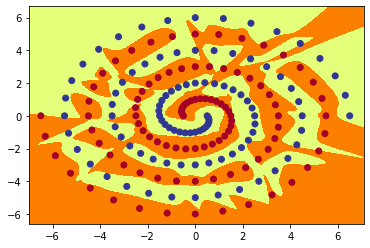

In [12]:
def graph_output(net):
    xrange = torch.arange(start=-7,end=7.1,step=0.01,dtype=torch.float32)
    yrange = torch.arange(start=-6.6,end=6.7,step=0.01,dtype=torch.float32)
    xcoord = xrange.repeat(yrange.size()[0])
    ycoord = torch.repeat_interleave(yrange, xrange.size()[0], dim=0)
    grid = torch.cat((xcoord.unsqueeze(1),ycoord.unsqueeze(1)),1)
    with torch.no_grad(): # suppress updating of gradients
        net.eval()        # toggle batch norm, dropout
        output = net(grid)
        net.train() # toggle batch norm, dropout back again
        #print('output',output, output.shape)
        pred = (output >= 0.5).float()
        #print('pred',pred, pred.shape)
        # plot function computed by model
        print(yrange.size()[0],xrange.size()[0])
        plt.clf()
        plt.pcolormesh(xrange,yrange,pred.cpu().view(yrange.size()[0],xrange.size()[0]), cmap='Wistia')

        #print(xrange.shape, yrange.shape, xcoord, ycoord)
        #print(grid.shape)
        #print(output.shape)
        #print(pred.shape)
        #print(net.fc1)
        
def graph_hidden(net, layer, node):
    #print(net, layer, node)
    #plt.clf()
    # INSERT CODE HERE
    xrange = torch.arange(start=-7,end=7.1,step=0.01,dtype=torch.float32)
    yrange = torch.arange(start=-6.6,end=6.7,step=0.01,dtype=torch.float32)
    xcoord = xrange.repeat(yrange.size()[0])
    ycoord = torch.repeat_interleave(yrange, xrange.size()[0], dim=0)
    grid = torch.cat((xcoord.unsqueeze(1),ycoord.unsqueeze(1)),1)
    with torch.no_grad(): # suppress updating of gradients
        net.eval()        # toggle batch norm, dropout
        #print('grid',grid, grid.shape)
        output = net(grid)
        net.train() # toggle batch norm, dropout back again
        output = ''
        if layer == 1 :
            output = net.h1 
        else:
            output = net.h2
        print('h output', output.shape)
        act_val = output[:,node]
        print('act_val',act_val, act_val.shape)
        pred = (act_val >= 0.5).float()
        #print('pred',pred, pred.shape)
        # plot function computed by model
        #print(yrange.size()[0],xrange.size()[0])
        plt.clf()
        plt.pcolormesh(xrange,yrange,pred.cpu().view(yrange.size()[0],xrange.size()[0]), cmap='Wistia')
        
        
        #print('pred',pred, pred.shape)
        #plot function computed by model
        #x = [node]*output.shape[0] 
        #print(x)
        #plt.scatter(x,act_val.detach().cpu().numpy())
        
argnet = 'short'
for layer in [1,2]:
    if layer == 1 or argnet != 'polar':
        for node in range(hid):
            graph_hidden(net, layer, node)
            #plt.scatter(full_input[:,0],full_input[:,1],c=1-full_target[:,0],cmap='RdYlBu')
            #plt.savefig('%s%d_%d.png' % (argnet, layer, node))
        

graph_output(net)
plt.scatter(full_input[:,0],full_input[:,1],c=1-full_target[:,0],cmap='RdYlBu')
plt.savefig('%s_out.png' % argnet)
        

    

[9 marks] Discuss what you have learned from this exercise, including the following points:

    a. the qualitative difference between the functions computed by the hidden layer nodes of the three models, and a brief description of how the network uses these functions to achieve the classification
    b. the effect of different values for initial weight size on the speed and success of learning, for both RawNet and ShortNet
    c. the relative "naturalness" of the output function computed by the three networks, and the importance of representation for deep learning tasks in general
    d. you may like to also experiment with other changes and comment on the result - for example, changing batch size from 97 to 194, using SGD instead of Adam, changing tanh to relu, adding a third hidden layer, etc
    